In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import random
import torch.optim as optim

In [47]:
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(1)

In [48]:
df = pd.read_csv("data_final.csv")
df = df.sort_values("observation_date")
df = df.reset_index(drop=True)

macro_features = [
    'FEDFUNDS',       # Federal Funds Rate
    'UNRATE',         # Unemployment Rate
    'GS10',           # 10-Year Treasury Yield
    'DTWEXBGS',       # Dollar Index
    'DCOILWTICO',     # Oil Prices
    'GOLD',           # Gold Prices
    'MOVE',           # MOVE Index
    'VIXCLS'          # Volatility Index (VIX)
]

technical_features = [
    'SMA_10',         # 10-day Simple Moving Average
    'SMA_50',         # 50-day Simple Moving Average
    'EMA_10',         # 10-day Exponential Moving Average
    'EMA_50',         # 50-day Exponential Moving Average
    'ROC_10',         # 10-day Rate of Change
    'RSI_14',         # 14-day Relative Strength Index
    'BB_upper',       # Upper Bollinger Band
    'BB_lower',       # Lower Bollinger Band
    'Volatility_20'   # 20-day Rolling Volatility
]


df['log_return'] = np.log(df['SP500'] / df['SP500'].shift(1))
df = df.dropna().reset_index(drop=True)

target = 'log_return'

X_macro = df[macro_features].values
y_macro = df[[target]].values
X_technical = df[technical_features].values
y_technical = df[[target]].values


In [49]:
def create_sequences(X, y, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])
    return torch.tensor(X_seq, dtype=torch.float32), torch.tensor(y_seq, dtype=torch.float32)

In [50]:
seq_length = 20

macro_scaler = MinMaxScaler()
X_macro_scaled = macro_scaler.fit_transform(X_macro)

tech_scaler = MinMaxScaler()
X_technical_scaled = tech_scaler.fit_transform(X_technical)

y_scaler = MinMaxScaler()
y_scaled = y_scaler.fit_transform(y_macro)  

X_macro_seq, y_macro_seq = create_sequences(X_macro_scaled, y_scaled, seq_length)
X_technical_seq, y_technical_seq = create_sequences(X_technical_scaled, y_scaled, seq_length)

In [51]:
def train_test_split(X, y, train_ratio=0.85):
    total = X.shape[0]
    train_end = int(total * train_ratio)
    X_train, y_train = X[:train_end], y[:train_end]
    X_test, y_test = X[train_end:], y[train_end:]
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = train_test_split(X_macro_seq, y_macro_seq)

In [52]:
class LinearRegressionModel(nn.Module):
    def __init__(self, input_size, seq_length):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_size * seq_length, 1)

    def forward(self, x):
        x = x.view(x.size(0), -1)  
        return self.linear(x)

input_size = X_train.shape[2]  
seq_length = X_train.shape[1]  

model = LinearRegressionModel(input_size, seq_length)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

num_epochs = 10000
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    output = model(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.6f}")

model.eval()
with torch.no_grad():
    predictions = model(X_test)
    test_loss = criterion(predictions, y_test)
    print(f"\nTest Loss: {test_loss.item():.6f}")

Epoch [1/10000], Train Loss: 0.250765
Epoch [2/10000], Train Loss: 0.210397
Epoch [3/10000], Train Loss: 0.174756
Epoch [4/10000], Train Loss: 0.143891
Epoch [5/10000], Train Loss: 0.117804
Epoch [6/10000], Train Loss: 0.096428
Epoch [7/10000], Train Loss: 0.079617
Epoch [8/10000], Train Loss: 0.067126
Epoch [9/10000], Train Loss: 0.058600
Epoch [10/10000], Train Loss: 0.053568
Epoch [11/10000], Train Loss: 0.051451
Epoch [12/10000], Train Loss: 0.051583
Epoch [13/10000], Train Loss: 0.053256
Epoch [14/10000], Train Loss: 0.055773
Epoch [15/10000], Train Loss: 0.058504
Epoch [16/10000], Train Loss: 0.060938
Epoch [17/10000], Train Loss: 0.062710
Epoch [18/10000], Train Loss: 0.063608
Epoch [19/10000], Train Loss: 0.063565
Epoch [20/10000], Train Loss: 0.062631
Epoch [21/10000], Train Loss: 0.060944
Epoch [22/10000], Train Loss: 0.058695
Epoch [23/10000], Train Loss: 0.056100
Epoch [24/10000], Train Loss: 0.053377
Epoch [25/10000], Train Loss: 0.050721
Epoch [26/10000], Train Loss: 0.04

Directional Accuracy: 45.76%


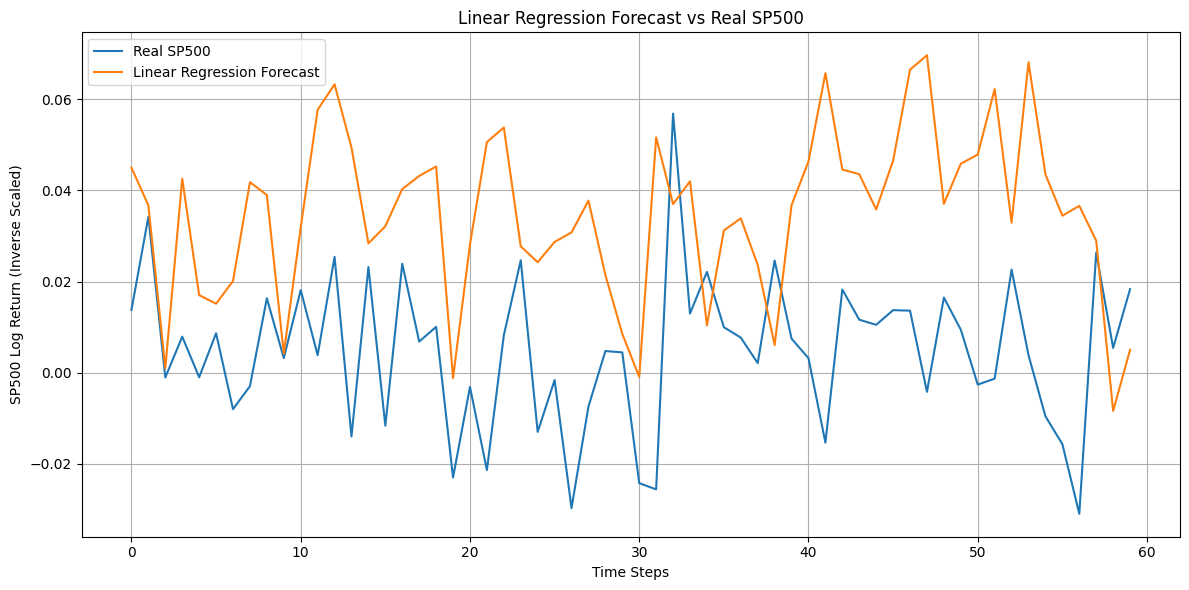

In [53]:
pred_inv = y_scaler.inverse_transform(predictions.numpy())
y_test_inv = y_scaler.inverse_transform(y_test.numpy())
real = y_test_inv.flatten()
pred = pred_inv.flatten()
real_diff = np.sign(np.diff(real))
pred_diff = np.sign(np.diff(pred))
directional_accuracy = np.mean(real_diff == pred_diff)
print(f"Directional Accuracy: {directional_accuracy:.2%}")

plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label="Real SP500")
plt.plot(pred_inv, label="Linear Regression Forecast")
plt.title("Linear Regression Forecast vs Real SP500")
plt.xlabel("Time Steps")
plt.ylabel("SP500 Log Return (Inverse Scaled)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Epoch [1/10000], Train Loss: 0.380286
Epoch [2/10000], Train Loss: 0.296026
Epoch [3/10000], Train Loss: 0.224485
Epoch [4/10000], Train Loss: 0.165745
Epoch [5/10000], Train Loss: 0.119667
Epoch [6/10000], Train Loss: 0.085812
Epoch [7/10000], Train Loss: 0.063349
Epoch [8/10000], Train Loss: 0.050988
Epoch [9/10000], Train Loss: 0.046957
Epoch [10/10000], Train Loss: 0.049076
Epoch [11/10000], Train Loss: 0.054952
Epoch [12/10000], Train Loss: 0.062260
Epoch [13/10000], Train Loss: 0.069041
Epoch [14/10000], Train Loss: 0.073904
Epoch [15/10000], Train Loss: 0.076100
Epoch [16/10000], Train Loss: 0.075460
Epoch [17/10000], Train Loss: 0.072265
Epoch [18/10000], Train Loss: 0.067088
Epoch [19/10000], Train Loss: 0.060651
Epoch [20/10000], Train Loss: 0.053703
Epoch [21/10000], Train Loss: 0.046930
Epoch [22/10000], Train Loss: 0.040890
Epoch [23/10000], Train Loss: 0.035973
Epoch [24/10000], Train Loss: 0.032381
Epoch [25/10000], Train Loss: 0.030135
Epoch [26/10000], Train Loss: 0.02

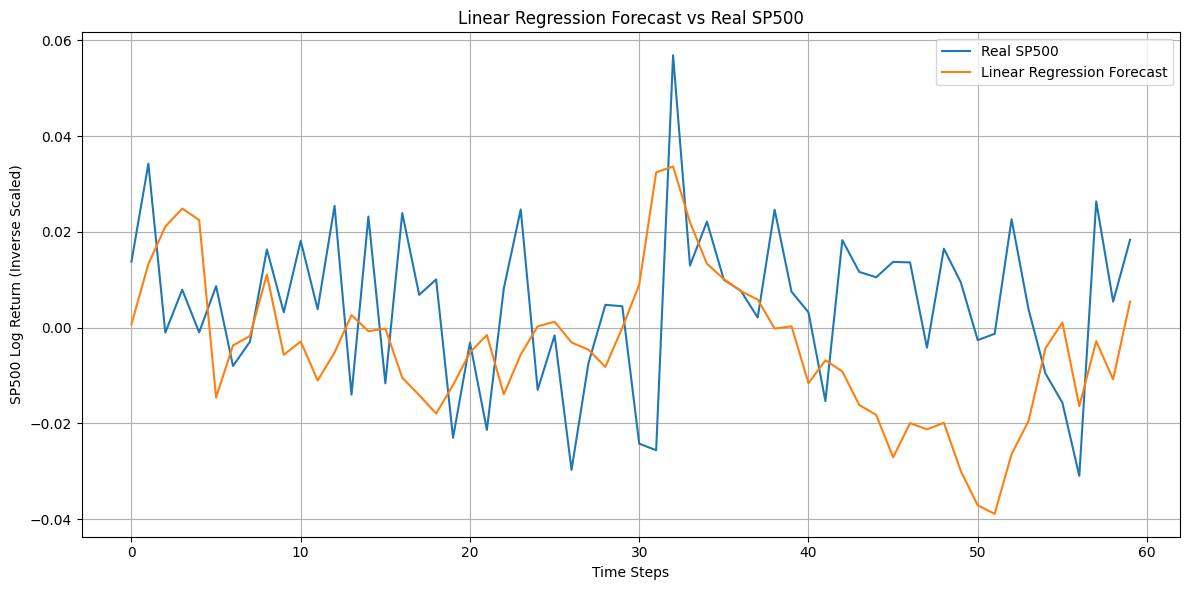

In [54]:
X_train, y_train, X_test, y_test = train_test_split(X_technical_seq, y_technical_seq)

class LinearRegressionModel(nn.Module):
    def __init__(self, input_size, seq_length):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_size * seq_length, 1)

    def forward(self, x):
        x = x.view(x.size(0), -1)  
        return self.linear(x)

input_size = X_train.shape[2]  
seq_length = X_train.shape[1]  

model = LinearRegressionModel(input_size, seq_length)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

num_epochs = 10000
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    output = model(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.6f}")

model.eval()
with torch.no_grad():
    predictions = model(X_test)
    test_loss = criterion(predictions, y_test)
    print(f"\nTest Loss: {test_loss.item():.6f}")

pred_inv = y_scaler.inverse_transform(predictions.numpy())
y_test_inv = y_scaler.inverse_transform(y_test.numpy())
real = y_test_inv.flatten()
pred = pred_inv.flatten()
real_diff = np.sign(np.diff(real))
pred_diff = np.sign(np.diff(pred))
directional_accuracy = np.mean(real_diff == pred_diff)
print(f"Directional Accuracy: {directional_accuracy:.2%}")

plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label="Real SP500")
plt.plot(pred_inv, label="Linear Regression Forecast")
plt.title("Linear Regression Forecast vs Real SP500")
plt.xlabel("Time Steps")
plt.ylabel("SP500 Log Return (Inverse Scaled)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Epoch [1/10000], Train Loss: 0.471911
Epoch [2/10000], Train Loss: 0.332153
Epoch [3/10000], Train Loss: 0.224222
Epoch [4/10000], Train Loss: 0.147829
Epoch [5/10000], Train Loss: 0.101316
Epoch [6/10000], Train Loss: 0.081013
Epoch [7/10000], Train Loss: 0.080831
Epoch [8/10000], Train Loss: 0.092710
Epoch [9/10000], Train Loss: 0.108237
Epoch [10/10000], Train Loss: 0.120709
Epoch [11/10000], Train Loss: 0.126346
Epoch [12/10000], Train Loss: 0.124214
Epoch [13/10000], Train Loss: 0.115394
Epoch [14/10000], Train Loss: 0.102048
Epoch [15/10000], Train Loss: 0.086678
Epoch [16/10000], Train Loss: 0.071623
Epoch [17/10000], Train Loss: 0.058729
Epoch [18/10000], Train Loss: 0.049164
Epoch [19/10000], Train Loss: 0.043348
Epoch [20/10000], Train Loss: 0.040988
Epoch [21/10000], Train Loss: 0.041223
Epoch [22/10000], Train Loss: 0.042870
Epoch [23/10000], Train Loss: 0.044695
Epoch [24/10000], Train Loss: 0.045681
Epoch [25/10000], Train Loss: 0.045206
Epoch [26/10000], Train Loss: 0.04

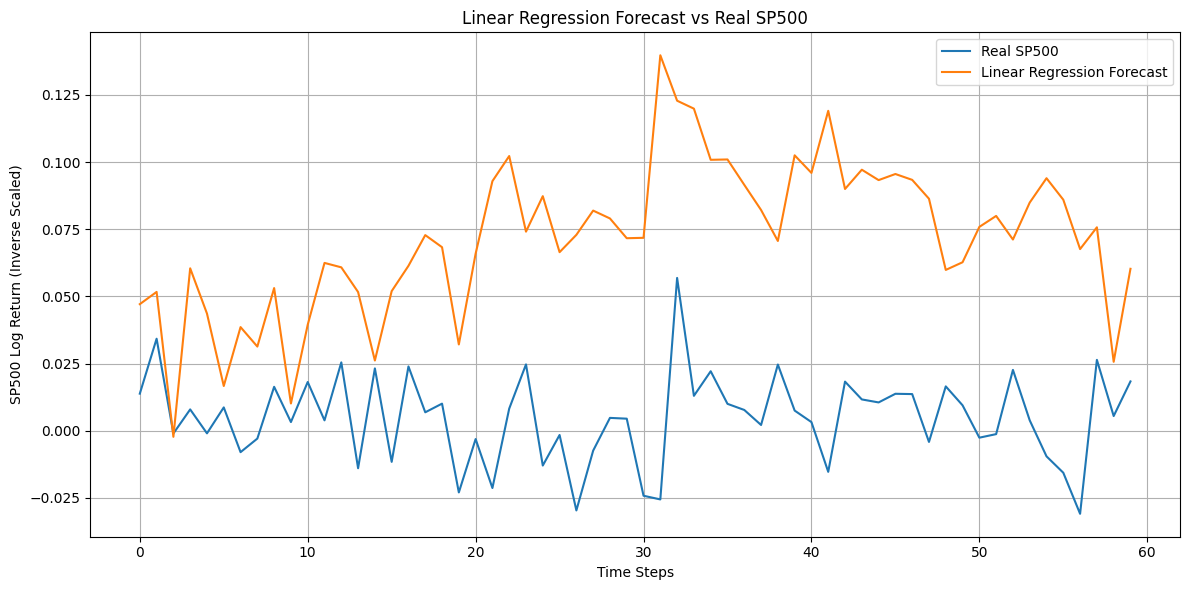

In [55]:
features = macro_features + technical_features
X_all = df[features].values
scaler_all = MinMaxScaler()
X_all_scaled = scaler_all.fit_transform(X_all)

X_all_seq, y_all_seq = create_sequences(X_all_scaled, y_scaled, seq_length)
X_train, y_train, X_test, y_test  = train_test_split(X_all_seq, y_all_seq)


class LinearRegressionModel(nn.Module):
    def __init__(self, input_size, seq_length):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_size * seq_length, 1)

    def forward(self, x):
        x = x.view(x.size(0), -1)  
        return self.linear(x)

input_size = X_train.shape[2]  
seq_length = X_train.shape[1]  

model = LinearRegressionModel(input_size, seq_length)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

num_epochs = 10000
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    output = model(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.6f}")

model.eval()
with torch.no_grad():
    predictions = model(X_test)
    test_loss = criterion(predictions, y_test)
    print(f"\nTest Loss: {test_loss.item():.6f}")

pred_inv = y_scaler.inverse_transform(predictions.numpy())
y_test_inv = y_scaler.inverse_transform(y_test.numpy())
real = y_test_inv.flatten()
pred = pred_inv.flatten()
real_diff = np.sign(np.diff(real))
pred_diff = np.sign(np.diff(pred))
directional_accuracy = np.mean(real_diff == pred_diff)
print(f"Directional Accuracy: {directional_accuracy:.2%}")

plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label="Real SP500")
plt.plot(pred_inv, label="Linear Regression Forecast")
plt.title("Linear Regression Forecast vs Real SP500")
plt.xlabel("Time Steps")
plt.ylabel("SP500 Log Return (Inverse Scaled)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()